# Signed Graph Network Analysis

## Setup

In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
from scipy.stats import norm


## Analysis

### A) Graph Import, Adjacency Matrix

In [2]:
# Import the weighted graph using the specified nodes in the first and second columns. The weight is specified in the third column. 
# Generate an adjacency matrix and save it to an Excel file.

In [3]:
graph_df = pd.read_csv("data/soc-sign-bitcoinalpha.csv", header=None)
graph_df.columns = ["source", "target", "weight", "time"]
G = nx.from_pandas_edgelist(graph_df, source="source", target="target", edge_attr="weight", create_using=nx.DiGraph)
graph_df

,source,target,weight,time
0,7188,1,10,1407470400
1,430,1,10,1376539200
2,3134,1,10,1369713600
3,3026,1,10,1350014400
4,3010,1,10,1347854400
...,...,...,...,...
24181,7604,7601,10,1364270400
24182,7601,7604,10,1364270400
24183,7604,7602,10,1364270400
24184,7602,7604,10,1364270400


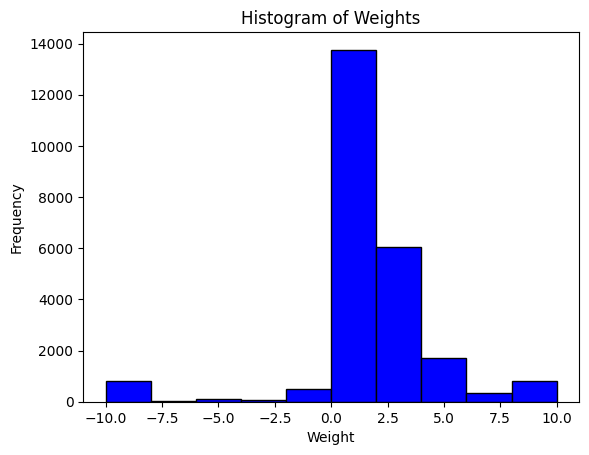

In [99]:
#histogram of weights 
plt.hist(graph_df["weight"], bins=10, color="blue", edgecolor="black")
plt.xlabel("Weight")
plt.ylabel("Frequency")
plt.savefig("plots/histogram_of_weights.pdf")
plt.title("Histogram of Weights")
plt.show()


In [4]:
adjacency_matrix = nx.adjacency_matrix(G).todense()
print("Shape of the adjacency matrix: ", adjacency_matrix.shape)

#save to excel file
adjacency_df = pd.DataFrame(adjacency_matrix)

#adjacency_df.to_excel("data/adjacency_matrix.csv", index=False) -> incredibly slow, therefore chose to save as csv
adjacency_df.to_csv("data/adjacency_matrix.csv", index=False, header=False)

Shape of the adjacency matrix:  (3783, 3783)


### B) Degree Distribtion, Power Law, 

In [5]:
# Using NetworkX, plot the in/out-degree distribution
# and fit the power-law distribution. Use curve fitting and
# confidence bounds of the curve fit library and evaluate
# if the power law distribution can be fit with 80%
# confidence. Additionally, calculate the average clustering
# coefficient and diameter.

In [81]:
def calculate_degrees(degree_dict):
    degree_sequence = sorted([d for n, d in degree_dict], reverse=True)
    degree_count = {}
    for degree in degree_sequence:
        if degree in degree_count:
            degree_count[degree] += 1
        else:
            degree_count[degree] = 1
    return zip(*degree_count.items())


def plot_degree(degree, count, title, save_path):
    plt.bar(degree, count, color='b', label = "NumberOfNodes")
    plt.xlabel("Degree")
    plt.ylabel("Count")
    plt.xlim(0, 100)
    plt.ylim(0, max(count))
    plt.legend()
    plt.savefig(f"plots/{save_path}.pdf")
    #keep title out of saved version
    plt.title(title)
    plt.show()

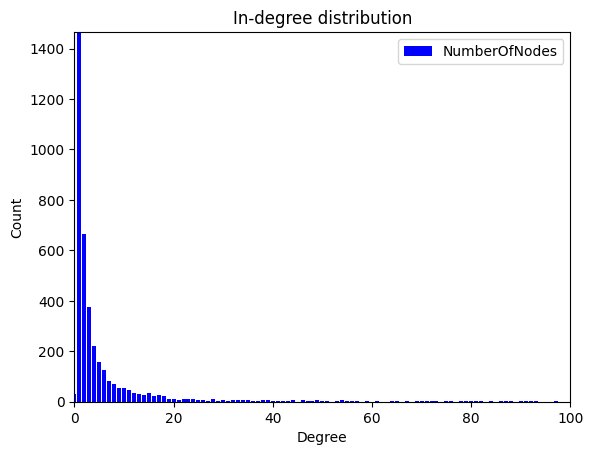

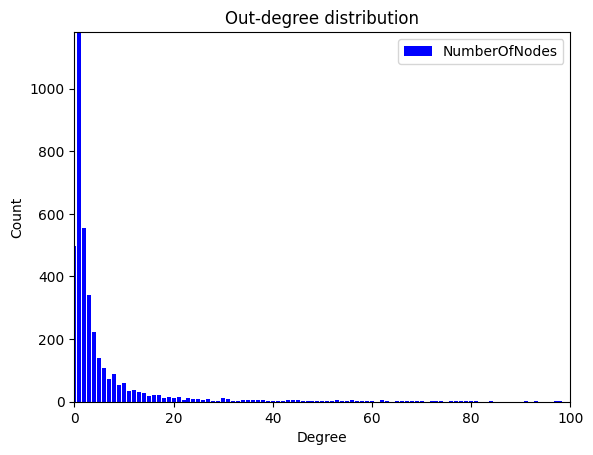

In [82]:
in_degree, in_count = calculate_degrees(G.in_degree())
plot_degree(in_degree, in_count, "In-degree distribution", "B_in_degree_distribution")
out_degree, out_count = calculate_degrees(G.out_degree())
plot_degree(out_degree, out_count, "Out-degree distribution", "B_out_degree_distribution")

In [88]:
# percentage of nodes with in / out degress under 20
in_degree_under_10= sum(in_count[-10:]) / sum(in_count)
out_degree_under_10 = sum(out_count[-10:]) / sum(out_count)

print(f"Percentage of nodes with in-degree under 10: {in_degree_under_10}")
print(f"Percentage of nodes with out-degree under 10: {out_degree_under_10}")

Percentage of nodes with in-degree under 20: 0.8569918054454136
Percentage of nodes with out-degree under 20: 0.8604282315622522


In [84]:
def linlaw(x, a, b) :
    return np.log(a) + x * b

def fit_and_plot_powerlaw(degree, count, title, save_path):
    degree, count = np.log(degree)[:-1], np.log(count)[:-1]
    popt_log, pcov_log = curve_fit(linlaw, degree, count)

    hires_x = np.linspace(0, max(degree), 100)
    # Calculate standard errors of the parameters
    sigma_ab = np.sqrt(np.diagonal(pcov_log))

    # Calculate critical value for an 80% confidence interval
    z = norm.ppf(0.9)  # for an 80% confidence interval

    # Calculate confidence bounds
    bound_upper = linlaw(hires_x, *(popt_log + z * sigma_ab))
    bound_lower = linlaw(hires_x, *(popt_log - z * sigma_ab))

    print(f"Optimal parameters: a={popt_log[0]}, b={popt_log[1]}")
    plt.scatter(degree, count, color='b')
    plt.plot(degree, linlaw(degree, *popt_log), 'r--', label = "Fitted Curve")
    plt.fill_between(hires_x, bound_lower, bound_upper, color='black', alpha=0.15, label='80% Confidence Interval')  # plotting the confidence intervals
    plt.xlabel("log(Degree)")
    plt.ylabel("log(Count)")
    plt.legend(loc='best')
    plt.savefig(f"plots/{save_path}.pdf")
    plt.title(title)
    plt.show()

/tmp/ipykernel_39530/2130378041.py:5: RuntimeWarning: divide by zero encountered in log
  degree, count = np.log(degree)[:-1], np.log(count)[:-1]


Optimal parameters: a=1050.1333867565952, b=-1.4768509049523104


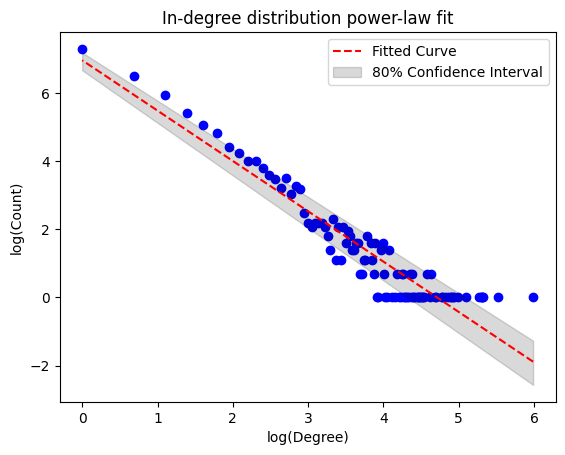

/tmp/ipykernel_39530/2130378041.py:5: RuntimeWarning: divide by zero encountered in log
  degree, count = np.log(degree)[:-1], np.log(count)[:-1]


Optimal parameters: a=745.6386171455763, b=-1.3892366867563806


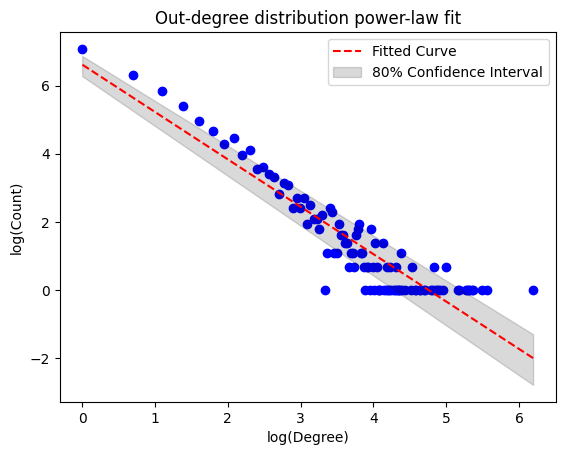

In [85]:
fit_and_plot_powerlaw(in_degree, in_count, "In-degree distribution power-law fit", "B_in_degree_distribution_powerlaw_fit")
fit_and_plot_powerlaw(out_degree, out_count, "Out-degree distribution power-law fit", "B_out_degree_distribution_powerlaw_fit")

In [67]:
#Additionally, calculate the average clustering coefficient and diameter.
average_clustering_coefficient = nx.average_clustering(G)
print("Average clustering coefficient: ", average_clustering_coefficient)

#identify biggest strongly connected component first
strongly_connected_components = nx.strongly_connected_components(G)
biggest_strongly_connected_component = max(strongly_connected_components, key=len)
G_strongly_connected = G.subgraph(biggest_strongly_connected_component)
diameter = nx.diameter(G_strongly_connected)
print("Diameter: ", diameter)


Average clustering coefficient:  0.15834486458303135
Diameter:  10


In [75]:
print(f"dropped nodes: {len(G.nodes) - len(biggest_strongly_connected_component)}")
print(f"dropped edges: {len(G.edges)-len(G_strongly_connected.edges)}")
print(f"nodes: {len(G.nodes)}")
print(f"edges: {len(G.edges)}")

dropped nodes: 548
dropped edges: 887
nodes: 3783
edges: 24186


In [68]:
#do same but treat graph as undirected
connected_components = nx.connected_components(G.to_undirected())
biggest_connected_component = max(connected_components, key=len)
G_connected = G.to_undirected().subgraph(biggest_connected_component)
diameter = nx.diameter(G_connected)
print("Diameter (undirected): ", diameter)

Diameter (undirected):  10


In [80]:
print(f"dropped nodes: {len(G.nodes) - len(biggest_connected_component)}")
print(f"dropped edges: {len(G.to_undirected().edges)-len(G_connected.edges)}")
print(f"nodes: {len(G.nodes)}")
print(f"edges: {len(G.to_undirected().edges)}")

dropped nodes: 8
dropped edges: 4
nodes: 3783
edges: 14124


### F) Link Sign Prediction

#### Create Feature DF

In [127]:
feature_df = graph_df[["source", "target", "weight"]]
#create edge column with tuple of source and target
feature_df["edge"] = list(zip(feature_df["source"], feature_df["target"]))
feature_df

,source,target,weight,edge
0,7188,1,10,"(7188, 1)"
1,430,1,10,"(430, 1)"
2,3134,1,10,"(3134, 1)"
3,3026,1,10,"(3026, 1)"
4,3010,1,10,"(3010, 1)"
...,...,...,...,...
24181,7604,7601,10,"(7604, 7601)"
24182,7601,7604,10,"(7601, 7604)"
24183,7604,7602,10,"(7604, 7602)"
24184,7602,7604,10,"(7602, 7604)"


In [117]:
#calcualte edge betweenness
edge_betweenness = nx.edge_betweenness_centrality(G, seed = 42)

In [125]:
#calcualte edge betweenness with weight
edge_betweenness_weighted = nx.edge_betweenness_centrality(G, weight = "weight", seed = 42)

In [ ]:
#calcualte edge betweenness with weight
edge_betweenness = nx.edge_betweenness_centrality(G, seed = 42)

In [118]:
#calculate degree centrality 
degree_centrality = nx.degree_centrality(G)

In [119]:
#calculate closeness centrality
closeness_centrality = nx.closeness_centrality(G)
closeness_centrality

{7188: 0.0,
 1: 0.3587718223102824,
 430: 0.2441359654296969,
 3134: 0.27113369809780447,
 3026: 0.25328500151903444,
 3010: 0.25328500151903444,
 804: 0.2756907909201678,
 160: 0.2674623921828729,
 95: 0.3372463757150159,
 377: 0.25365148370607593,
 888: 0.25853793960934535,
 89: 0.3101711939424735,
 1901: 0.25328500151903444,
 161: 0.2908116233096721,
 256: 0.3002438564356441,
 351: 0.27978833983259727,
 3329: 0.25328500151903444,
 3341: 0.25328500151903444,
 649: 0.28223768432499374,
 1583: 0.25328500151903444,
 87: 0.3096233697783185,
 37: 0.30948671596841965,
 309: 0.2946919633139092,
 821: 0.2618200417083718,
 1496: 0.25650462796724166,
 637: 0.27631544742604547,
 964: 0.2762610171202391,
 594: 0.2641128160849141,
 2249: 0.25328500151903444,
 554: 0.2678966673182223,
 20: 0.3192440367427484,
 2227: 0.25328500151903444,
 1315: 0.2533994133907117,
 519: 0.2847881111607054,
 1316: 0.25328500151903444,
 2149: 0.2538580963726842,
 1724: 0.2618444834598383,
 18: 0.3120344984783388,
 57

In [128]:
#add edge_betweenness to feature_df
feature_df["edge_betweenness"] = feature_df["edge"].map(edge_betweenness)

#add weighted weighted_edge betweenness
feature_df["edge_betweenness_weighted"] = feature_df["edge"].map(edge_betweenness_weighted)

#add degree centrality to feature_df
feature_df["degree_centrality_source"] = feature_df["source"].map(degree_centrality)
feature_df["degree_centrality_target"] = feature_df["target"].map(degree_centrality)
feature_df["degree_centrality"] = (feature_df["degree_centrality_source"] + feature_df["degree_centrality_target"]) / 2

#add closeness centrality to feature_df
feature_df["closeness_centrality_source"] = feature_df["source"].map(closeness_centrality)
feature_df["closeness_centrality_target"] = feature_df["target"].map(closeness_centrality)
feature_df["closeness_centrality"] = (feature_df["closeness_centrality_source"] + feature_df["closeness_centrality_target"]) / 2

#add sign to feature_df
feature_df["sign"] = np.sign(feature_df['weight'])

#save df
#feature_df.to_csv("data/feature_df.csv", index=False)
feature_df

,source,target,weight,edge,edge_betweenness,edge_betweenness_weighted,degree_centrality_source,degree_centrality_target,degree_centrality,closeness_centrality_source,closeness_centrality_target,closeness_centrality,sign
0,7188,1,10,"(7188, 1)",0.000262,0.000248,0.000264,0.234796,0.117530,0.000000,0.358772,0.179386,1
1,430,1,10,"(430, 1)",0.000416,0.000000,0.003966,0.234796,0.119381,0.244136,0.358772,0.301454,1
2,3134,1,10,"(3134, 1)",0.000111,0.000000,0.001851,0.234796,0.118324,0.271134,0.358772,0.314953,1
3,3026,1,10,"(3026, 1)",0.000262,0.000247,0.000529,0.234796,0.117663,0.253285,0.358772,0.306028,1
4,3010,1,10,"(3010, 1)",0.000262,0.000247,0.000529,0.234796,0.117663,0.253285,0.358772,0.306028,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
24181,7604,7601,10,"(7604, 7601)",0.000019,0.000000,0.024855,0.007139,0.015997,0.318664,0.279984,0.299324,1
24182,7601,7604,10,"(7601, 7604)",0.000007,0.000000,0.007139,0.024855,0.015997,0.279984,0.318664,0.299324,1
24183,7604,7602,10,"(7604, 7602)",0.000017,0.000000,0.024855,0.007932,0.016393,0.318664,0.283694,0.301179,1
24184,7602,7604,10,"(7602, 7604)",0.000005,0.000000,0.007932,0.024855,0.016393,0.283694,0.318664,0.301179,1


#### Load Feature DF

In [4]:
feature_df = pd.read_csv("data/feature_df.csv")
feature_df

,source,target,weight,edge,edge_betweenness,edge_betweenness_weighted,degree_centrality_source,degree_centrality_target,degree_centrality,closeness_centrality_source,closeness_centrality_target,closeness_centrality,sign
0,7188,1,10,"(7188, 1)",0.000262,0.000248,0.000264,0.234796,0.117530,0.000000,0.358772,0.179386,1
1,430,1,10,"(430, 1)",0.000416,0.000000,0.003966,0.234796,0.119381,0.244136,0.358772,0.301454,1
2,3134,1,10,"(3134, 1)",0.000111,0.000000,0.001851,0.234796,0.118324,0.271134,0.358772,0.314953,1
3,3026,1,10,"(3026, 1)",0.000262,0.000247,0.000529,0.234796,0.117663,0.253285,0.358772,0.306028,1
4,3010,1,10,"(3010, 1)",0.000262,0.000247,0.000529,0.234796,0.117663,0.253285,0.358772,0.306028,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
24181,7604,7601,10,"(7604, 7601)",0.000019,0.000000,0.024855,0.007139,0.015997,0.318664,0.279984,0.299324,1
24182,7601,7604,10,"(7601, 7604)",0.000007,0.000000,0.007139,0.024855,0.015997,0.279984,0.318664,0.299324,1
24183,7604,7602,10,"(7604, 7602)",0.000017,0.000000,0.024855,0.007932,0.016393,0.318664,0.283694,0.301179,1
24184,7602,7604,10,"(7602, 7604)",0.000005,0.000000,0.007932,0.024855,0.016393,0.283694,0.318664,0.301179,1


#### Train Models

In [28]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score,confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [39]:
samplers = [RandomOverSampler(random_state=42), SMOTE(random_state=42), RandomUnderSampler(random_state=42)] #
sampler_names = ["RandomOverSampler","SMOTE","RandomUnderSampler"] #
dfs = []
for sampler_name, sampler in zip(sampler_names, samplers):
    print(f"Using {sampler_name}")
    X = feature_df[["edge_betweenness", "degree_centrality", "closeness_centrality"]].to_numpy()
    y = feature_df["sign"].to_numpy()
    #change -1 to 0
    y[y == -1] = 0

    # ros = RandomOverSampler(random_state=42)
    # X, y = ros.fit_resample(X, y)
    # smote = SMOTE(random_state=42)
    # X, y = smote.fit_resample(X, y)
    # rus = RandomUnderSampler(random_state=42)
    
    X, y = sampler.fit_resample(X, y)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)



    # Initialize models
    models = {
        'Decision Tree': DecisionTreeClassifier(),
        'Random Forest': RandomForestClassifier(),
        'XGBoost': XGBClassifier(),
        'Support Vector Machine': SVC(),
        'Naive Bayes': GaussianNB(),
        'Neural Network': MLPClassifier(),
        'K-Nearest Neighbors': KNeighborsClassifier(),
        'Logistic Regression': LogisticRegression()
        }

    # Training and evaluation loop
    accuracy_scores = []
    f1_scores = []

    for name, model in models.items():
        # Train the model
        model.fit(X_train, y_train)
        
        # Make predictions on the test set
        y_pred = model.predict(X_test)
        
        # Calculate accuracy
        accuracy = accuracy_score(y_test, y_pred)

        #calculate f1 score
        f1 = f1_score(y_test, y_pred)
        
        # Print the accuracy of each model
        # print(f'{name} Accuracy: {accuracy:.4f}')
        # print(f'{name} F1 Score: {f1:.4f}')
        accuracy_scores.append(accuracy)
        f1_scores.append(f1)

        # print confusion matrix
        print(f'{name} Confusion Matrix:')
        print(confusion_matrix(y_test, y_pred))
    
    # Save the accuracy and f1 scores for each sampler
    df = pd.DataFrame({'Model': list(models.keys()), 'Accuracy': accuracy_scores, 'F1 Score': f1_scores})
    dfs.append(df)
    



Using RandomOverSampler


Decision Tree Confusion Matrix:
[[4522    4]
 [ 243 4291]]
Random Forest Confusion Matrix:
[[4522    4]
 [  66 4468]]
XGBoost Confusion Matrix:
[[4231  295]
 [ 703 3831]]
Support Vector Machine Confusion Matrix:
[[3245 1281]
 [2594 1940]]
Naive Bayes Confusion Matrix:
[[3612  914]
 [3025 1509]]


/home/cernerrood246/anaconda3/envs/SN/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Neural Network Confusion Matrix:
[[2720 1806]
 [1730 2804]]
K-Nearest Neighbors Confusion Matrix:
[[4522    4]
 [ 771 3763]]
Logistic Regression Confusion Matrix:
[[2894 1632]
 [2460 2074]]
Using SMOTE
Decision Tree Confusion Matrix:
[[3914  612]
 [ 633 3901]]
Random Forest Confusion Matrix:
[[4070  456]
 [ 547 3987]]
XGBoost Confusion Matrix:
[[3756  770]
 [1053 3481]]
Support Vector Machine Confusion Matrix:
[[3141 1385]
 [2449 2085]]
Naive Bayes Confusion Matrix:
[[3757  769]
 [3163 1371]]


/home/cernerrood246/anaconda3/envs/SN/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Neural Network Confusion Matrix:
[[2691 1835]
 [1860 2674]]
K-Nearest Neighbors Confusion Matrix:
[[4167  359]
 [1101 3433]]
Logistic Regression Confusion Matrix:
[[2932 1594]
 [2488 2046]]
Using RandomUnderSampler
Decision Tree Confusion Matrix:
[[191 125]
 [120 179]]
Random Forest Confusion Matrix:
[[198 118]
 [116 183]]
XGBoost Confusion Matrix:
[[205 111]
 [110 189]]
Support Vector Machine Confusion Matrix:
[[244  72]
 [188 111]]
Naive Bayes Confusion Matrix:
[[267  49]
 [226  73]]


/home/cernerrood246/anaconda3/envs/SN/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Neural Network Confusion Matrix:
[[216 100]
 [161 138]]
K-Nearest Neighbors Confusion Matrix:
[[204 112]
 [127 172]]
Logistic Regression Confusion Matrix:
[[174 142]
 [164 135]]


In [34]:
dfs[0]

,Model,Accuracy,F1 Score
0,Decision Tree,0.972958,0.972257
1,Random Forest,0.991170,0.991111
2,XGBoost,0.889845,0.884758
3,Support Vector Machine,0.572296,0.500322
4,Naive Bayes,0.565232,0.433808
5,Neural Network,0.608057,0.631830
6,K-Nearest Neighbors,0.914459,0.906638
7,Logistic Regression,0.548344,0.503398


In [36]:
dfs[1]

,Model,Accuracy,F1 Score
0,Decision Tree,0.863576,0.863032
1,Random Forest,0.886534,0.885676
2,XGBoost,0.798786,0.792487
3,Support Vector Machine,0.576821,0.520990
4,Naive Bayes,0.566004,0.410848
5,Neural Network,0.596358,0.570220
6,K-Nearest Neighbors,0.838852,0.824646
7,Logistic Regression,0.549448,0.500612


In [38]:
dfs[2]

,Model,Accuracy,F1 Score
0,Decision Tree,0.603252,0.596026
1,Random Forest,0.613008,0.605960
2,XGBoost,0.640650,0.631052
3,Support Vector Machine,0.577236,0.460581
4,Naive Bayes,0.552846,0.346793
5,Neural Network,0.582114,0.512334
6,K-Nearest Neighbors,0.611382,0.590051
7,Logistic Regression,0.502439,0.468750


#### Interpret Models

In [51]:
feature_importance = []
for sampler in [RandomOverSampler(random_state=42), SMOTE(random_state=42), RandomUnderSampler(random_state=42)]:

    X = feature_df[["edge_betweenness", "degree_centrality", "closeness_centrality"]].to_numpy()
    y = feature_df["sign"].to_numpy()
    #change -1 to 0
    y[y == -1] = 0
    X, y = sampler.fit_resample(X, y)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    model = XGBClassifier()
    model.fit(X_train, y_train)

    feature_importance.append(model.feature_importances_)

feature_importance 

[array([0.32744834, 0.35343608, 0.31911558], dtype=float32),
 array([0.30996463, 0.38932702, 0.3007084 ], dtype=float32),
 array([0.3497686 , 0.33616048, 0.3140709 ], dtype=float32)]

### G) Link Weight Prediction

In [60]:
feature_df = pd.read_csv("data/feature_df.csv")
feature_df

,source,target,weight,edge,edge_betweenness,edge_betweenness_weighted,degree_centrality_source,degree_centrality_target,degree_centrality,closeness_centrality_source,closeness_centrality_target,closeness_centrality,sign
0,7188,1,10,"(7188, 1)",0.000262,0.000248,0.000264,0.234796,0.117530,0.000000,0.358772,0.179386,1
1,430,1,10,"(430, 1)",0.000416,0.000000,0.003966,0.234796,0.119381,0.244136,0.358772,0.301454,1
2,3134,1,10,"(3134, 1)",0.000111,0.000000,0.001851,0.234796,0.118324,0.271134,0.358772,0.314953,1
3,3026,1,10,"(3026, 1)",0.000262,0.000247,0.000529,0.234796,0.117663,0.253285,0.358772,0.306028,1
4,3010,1,10,"(3010, 1)",0.000262,0.000247,0.000529,0.234796,0.117663,0.253285,0.358772,0.306028,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
24181,7604,7601,10,"(7604, 7601)",0.000019,0.000000,0.024855,0.007139,0.015997,0.318664,0.279984,0.299324,1
24182,7601,7604,10,"(7601, 7604)",0.000007,0.000000,0.007139,0.024855,0.015997,0.279984,0.318664,0.299324,1
24183,7604,7602,10,"(7604, 7602)",0.000017,0.000000,0.024855,0.007932,0.016393,0.318664,0.283694,0.301179,1
24184,7602,7604,10,"(7602, 7604)",0.000005,0.000000,0.007932,0.024855,0.016393,0.283694,0.318664,0.301179,1


In [61]:
samplers = [RandomOverSampler(random_state=42), SMOTE(random_state=42), RandomUnderSampler(random_state=42)] #
sampler_names = ["RandomOverSampler","SMOTE","RandomUnderSampler"] #
dfs = []
for sampler_name, sampler in zip(sampler_names, samplers):
    print(f"Using {sampler_name}")
    X = feature_df[["edge_betweenness", "degree_centrality", "closeness_centrality"]].to_numpy()
    y = feature_df["weight"].to_numpy()

    y = y + 10 #shift to 0-20
    
    X, y = sampler.fit_resample(X, y)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)



    # Initialize models
    models = {
        'Decision Tree': DecisionTreeClassifier(),
        'Random Forest': RandomForestClassifier(),
        'XGBoost': XGBClassifier(),
        'Support Vector Machine': SVC(),
        'Naive Bayes': GaussianNB(),
        'Neural Network': MLPClassifier(),
        'K-Nearest Neighbors': KNeighborsClassifier(),
        'Logistic Regression': LogisticRegression()
        }

    # Training and evaluation loop
    accuracy_scores = []
    f1_scores = []

    for name, model in models.items():
        # Train the model
        model.fit(X_train, y_train)
        
        # Make predictions on the test set
        y_pred = model.predict(X_test)
        
        # Calculate accuracy
        accuracy = accuracy_score(y_test, y_pred)

        #calculate f1 score
        f1 = f1_score(y_test, y_pred, average = "micro")
        
        # Print the accuracy of each model
        # print(f'{name} Accuracy: {accuracy:.4f}')
        # print(f'{name} F1 Score: {f1:.4f}')
        accuracy_scores.append(accuracy)
        f1_scores.append(f1)

        # print confusion matrix
        # print(f'{name} Confusion Matrix:')
        # print(confusion_matrix(y_test, y_pred))
    
    # Save the accuracy and f1 scores for each sampler
    df = pd.DataFrame({'Model': list(models.keys()), 'Accuracy': accuracy_scores, 'F1 Score': f1_scores})
    dfs.append(df)

Using RandomOverSampler


ValueError: Invalid classes inferred from unique values of `y`.  Expected: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19], got [ 0  1  2  3  4  5  6  7  8  9 11 12 13 14 15 16 17 18 19 20]

In [57]:
y

array([30, 30, 30, ..., 30, 30, 30])